In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from bson import json_util, ObjectId
from collections import Counter
import seaborn as sns
sns.set_style("whitegrid")

from scipy.stats import gaussian_kde, entropy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
O = nx.read_gpickle('../charlie_results/empirical_graph.gpickle')

## Finding $\mu$

In [8]:
def media_recit(G):
    list_c = []
    for node in G.nodes():
        dates_list = [G.node[j]['date'] for j in G.successors(node)]
        if dates_list != []:
            delta_t = max(dates_list) - G.node[node]['date']
            dif = delta_t.total_seconds()/(3600*24)
            if dif > 7:
                print(node)
            list_c.append([G.node[node]['date'].date(),dif])
        else:
            list_c.append([G.node[node]['date'].date(),0])
    return list_c

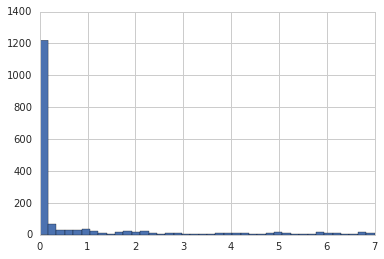

In [10]:
a = media_recit(O)
b = [i[1] for i in a]
plt.hist(b,bins=40)
plt.plot()
plt.show()

In [11]:
t = 1/mean(b)
print(t)

1.14318924219


## Finding $\lambda$

In [8]:
y  = np.loadtxt('../charlie_results/y.csv', delimiter=",")
x  = np.loadtxt('../charlie_results/x.csv', delimiter=",")

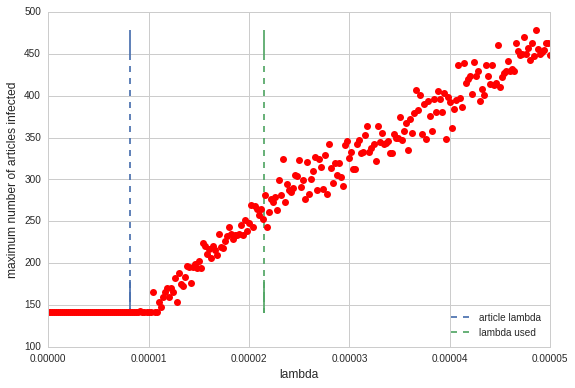

In [9]:
plt.figure(figsize=(9, 6))
plt.plot(len(x)*[8.12645449413e-06], y,'--')
plt.plot(len(x)*[0.0000215], y, '--')
plt.legend(['article lambda','lambda used'], loc=4)
plt.plot(x,y,'ro')
plt.xlabel('lambda',size=12)
plt.ylabel('number of articles at max(rho)', size=12)
plt.savefig('../charlie_results/lambda_validation', dpi=300)

## Validating the model

In [3]:
time_list = [O.node[node]['date'] for node in O.nodes()] 
dic = Counter(time_list)

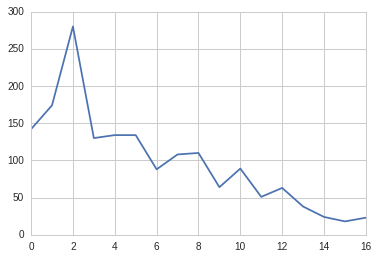

In [4]:
t0 = min(time_list)
d = []
for pos,i in enumerate(time_list):
    dif = time_list[pos].date() - t0.date()
    d.append(dif.days)
    
dic = Counter(d)
p=[]
q=[]
i=0

while len(q) < 17: 
    q.append(dic[i])
    i += 1
    
plt.plot(q)

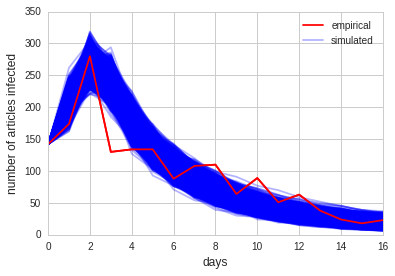

In [29]:
line_down = plt.plot(b,q,'r')

for i in range(0,9999):
    Infects = np.loadtxt(open('../charlie_results/Is/Infects%s.csv' %i), delimiter=",")
    a = list(Infects.sum(axis=1))
    b = [pos for pos,i in enumerate(a)]
    line_up = plt.plot(b,a,'b',':o',alpha=0.3)
    
plt.xlabel('time(days)',size=12)
plt.ylabel('number of articles infected',size=12)
plt.legend(['empirical', 'simulated'])
line_down = plt.plot(b,q,'r')


plt.savefig('../charlie_results/sim_compar.png', dip=300)

## Creating simulated graph

In [45]:
Infects = np.loadtxt(open('../charlie_results/Infects2.csv'), delimiter=",")
G = np.loadtxt(open('../charlie_results/graph_complete.csv'), delimiter=",")

In [16]:
def graph_simu_nx(Infects, G):
    s = Infects.shape[1]
    graph_sim = nx.DiGraph()

    #I_previous é o vetor de indices dos nos infectados no tempo 0
    I_previous = np.where(Infects[0]==1)[0]

    for i in I_previous:
        graph_sim.add_node(i)

    #done é a lista com os indices dos nos que ja descobrimos o pai
    done = list(I_previous.copy())

    for status in Infects[1:]:
        I = list(np.where(status==1)[0])
        I_current = I.copy()
        for article in done:
            if article in I_current:
                I_current.remove(article)

        if len(I_current) == 0:
            continue

        #se temos mais de uma possibilidade de pai
        if len(I_previous) == 1:
            for node in I_current:
                graph_sim.add_edge(I_previous[0],node)
                done.append(node)

        else:
            #calcular pai para cada no que foi infectado
            for node in I_current:
                #pegando a probabilidade de cada no ja infectado ter infectado o no node
                influences = G[node]
                probs = [influences[i] for i in I_previous]

                if sum(probs) != 0 :
                    probs = probs/sum(probs)
                else:
                    # se o no nao foi influenciado por ninguem entao nao pode ser influenciador
                    Infects[:, node] = np.zeros(Infects.shape[0])
                    done.append(node)
                    continue

                pos = np.random.choice(len(probs), 1, p=probs)
                graph_sim.add_edge(I_previous[pos[0]], node)
                done.append(node)
        I_previous = I

    return graph_sim

In [25]:
def cria_atribs_step(G,list):
    for i in list:
        for node in G.successors(i):
            G.node[node]['step'] = G.node[i]['step'] + 1
        cria_atribs_step(G,G.successors(i))
    return G

In [46]:
sim = graph_simu_nx(Infects, G)

In [47]:
sim.number_of_nodes()

1713

In [48]:
# lista_0 = np.where(Infects[0]==1)[0]
lista_0 =[0]
for i in lista_0:
    sim.node[i]['step']=0

In [49]:
sim_s = cria_atribs_step(sim, lista_0)

In [50]:
nx.write_graphml(sim_s, '../charlie_results/graph_simulated.graphml')